In [1]:
import pandas as pd

# Load your metadata CSV and drop columns 51 and 52
metadata_path = r'C:/Users/nirmi/train-metadata.csv'
metadata = pd.read_csv(metadata_path, low_memory=False)

# Drop columns 51 and 52
metadata = metadata.drop(columns=[metadata.columns[51], metadata.columns[52]])

# Normalize the labels by stripping any leading/trailing spaces and converting to lowercase
metadata['iddx_1'] = metadata['iddx_1'].str.strip().str.lower()

# Check unique values in the 'iddx_1' column to identify any inconsistencies
unique_labels = metadata['iddx_1'].unique()
print("Unique labels in 'iddx_1':", unique_labels)

# Count the number of benign and malignant cases (case-insensitive search)
benign_count = metadata[metadata['iddx_1'].str.contains('benign', case=False, na=False)].shape[0]
malignant_count = metadata[metadata['iddx_1'].str.contains('malignant', case=False, na=False)].shape[0]

print(f"Number of Benign cases: {benign_count}")
print(f"Number of Malignant cases: {malignant_count}")

# Inspect a few rows where the label contains 'malignant' to ensure they are correctly labeled
malignant_cases = metadata[metadata['iddx_1'].str.contains('malignant', case=False, na=False)]
print("\nSample of malignant cases:")
print(malignant_cases.head(10))


Unique labels in 'iddx_1': ['benign' 'malignant' 'indeterminate']
Number of Benign cases: 400552
Number of Malignant cases: 393

Sample of malignant cases:
           isic_id  target  patient_id  age_approx     sex  \
387   ISIC_0082829       1  IP_3249371        80.0  female   
935   ISIC_0096034       1  IP_6723298        75.0    male   
1245  ISIC_0104229       1  IP_9057861        80.0    male   
1846  ISIC_0119495       1  IP_6856511        60.0    male   
3478  ISIC_0157834       1  IP_3927284        55.0    male   
4812  ISIC_0190307       1  IP_4890448        65.0    male   
5673  ISIC_0211092       1  IP_2203964        65.0    male   
6057  ISIC_0220459       1  IP_7346729        65.0    male   
6741  ISIC_0238218       1  IP_6356898        55.0    male   
8204  ISIC_0275647       1  IP_7411721        45.0    male   

     anatom_site_general  clin_size_long_diam_mm          image_type  \
387       anterior torso                    9.27  TBP tile: close-up   
935            he

Displaying 3 Benign Images:


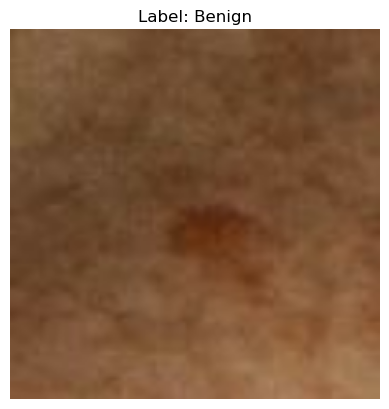

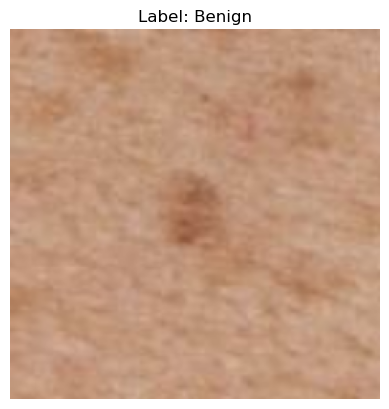

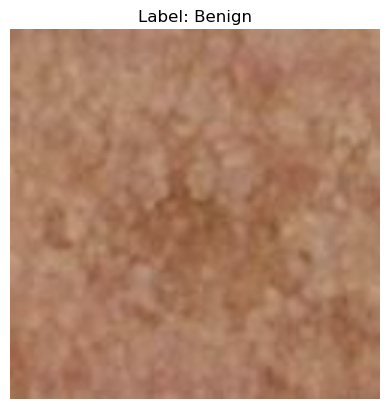


Displaying 3 Malignant Images:


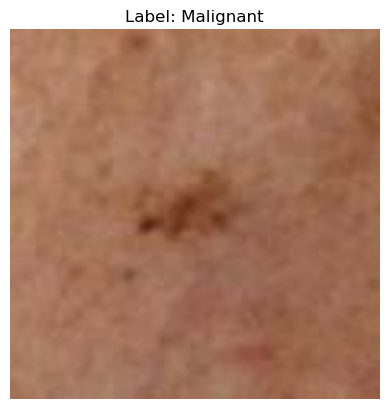

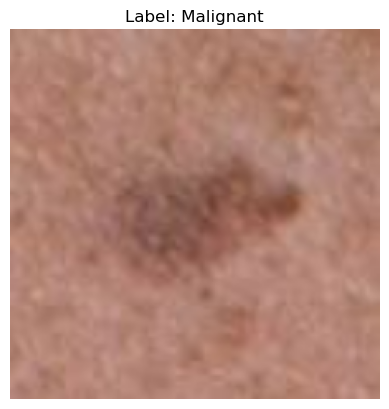

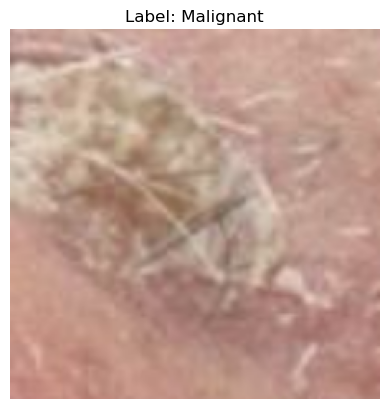

In [2]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load your metadata CSV
metadata_path = r'C:/Users/nirmi/train-metadata.csv'
metadata = pd.read_csv(metadata_path, low_memory=False)

# Drop columns 51 and 52 (if necessary)
metadata = metadata.drop(columns=[metadata.columns[51], metadata.columns[52]])

# Sample benign cases to match the number of malignant cases
benign_sample = metadata[metadata['iddx_1'].str.contains('benign', case=False, na=False)].sample(n=malignant_count, random_state=42)
malignant_sample = metadata[metadata['iddx_1'].str.contains('malignant', case=False, na=False)]

# Combine the samples to create a balanced dataset
balanced_metadata = pd.concat([benign_sample, malignant_sample])

# Split the balanced data into train and validation sets
train_df, val_df = train_test_split(balanced_metadata, test_size=0.2, random_state=42)

# Load HDF5 file
hdf5_file_path = r'C:/Users/nirmi/train.hdf5'
hdf5_file = h5py.File(hdf5_file_path, 'r')

# Function to load raw images from HDF5 without any preprocessing
def load_raw_image_from_hdf5(isic_id):
    if isic_id in hdf5_file:
        image_data = hdf5_file[isic_id][()]
        image = tf.image.decode_jpeg(image_data, channels=3)  # Decode the image
        image = tf.image.resize(image, [224, 224])  # Resize to 224x224 pixels
        image = tf.clip_by_value(image, 0, 255)  # Ensure pixel values are within [0, 255]
        image = tf.cast(image, tf.uint8)  # Convert to uint8 type for proper display
        return image
    else:
        raise ValueError(f"isic_id {isic_id} not found in HDF5 file")

# Function to display an image and its label
def display_image(isic_id, label, hdf5_file):
    image = load_raw_image_from_hdf5(isic_id)  # Load raw image with no preprocessing
    plt.imshow(image.numpy())
    plt.title(f"Label: {'Malignant' if label == 1.0 else 'Benign'}")
    plt.axis('off')
    plt.show()

# Display the first 3 Benign images
print("Displaying 3 Benign Images:")
benign_images = train_df[train_df['iddx_1'] == 'Benign'].head(3)
for index, row in benign_images.iterrows():
    isic_id = row['isic_id']
    label = 0.0  # Benign
    display_image(isic_id, label, hdf5_file)

# Display the first 3 Malignant images
print("\nDisplaying 3 Malignant Images:")
malignant_images = train_df[train_df['iddx_1'] == 'Malignant'].head(3)
for index, row in malignant_images.iterrows():
    isic_id = row['isic_id']
    label = 1.0  # Malignant
    display_image(isic_id, label, hdf5_file)


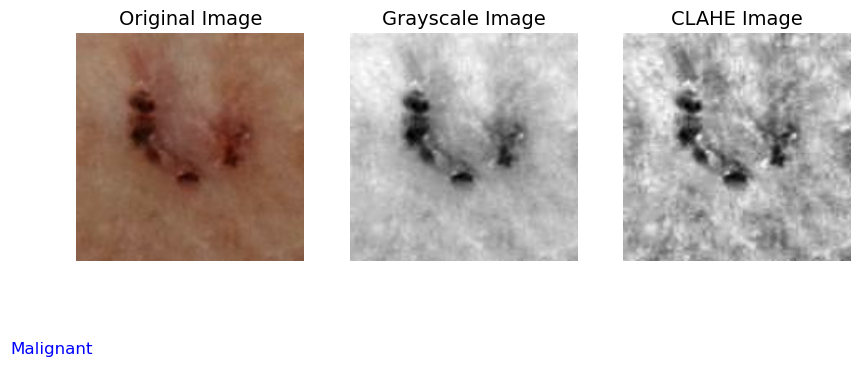

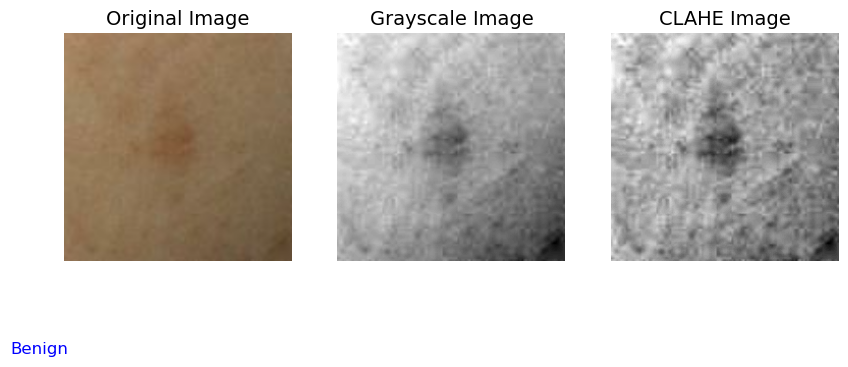

In [3]:
import pandas as pd
import h5py
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load your metadata CSV
metadata_path = r'C:/Users/nirmi/train-metadata.csv'
metadata = pd.read_csv(metadata_path, low_memory=False)

# Normalize the labels by stripping any leading/trailing spaces and converting to lowercase
metadata['iddx_1'] = metadata['iddx_1'].str.strip().str.lower()

# Load the HDF5 file
hdf5_file_path = r'C:/Users/nirmi/train.hdf5'
hdf5_file = h5py.File(hdf5_file_path, 'r')

# Function to load and preprocess an image from the HDF5 file
def load_and_preprocess_image_from_hdf5(isic_id):
    if isic_id in hdf5_file:
        image_data = hdf5_file[isic_id][()]
        image = tf.image.decode_jpeg(image_data, channels=3).numpy()  # Decode the image
        image = cv2.resize(image, (224, 224))  # Resize to 224x224 pixels
        
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        clahe_image = clahe.apply(gray_image)
        
        return image, gray_image, clahe_image
    else:
        raise ValueError(f"isic_id {isic_id} not found in HDF5 file")

# Dictionary to store processed images
processed_images = {}

# IDs of the images to display and label
malignant_ids = ['ISIC_0082829']
benign_ids = ['ISIC_0082517']

# Function to display and label images
def display_images(isic_id, label):
    original_image, gray_image, clahe_image = load_and_preprocess_image_from_hdf5(isic_id)
    
    # Store processed images in the dictionary
    processed_images[isic_id] = {
        'original': original_image,
        'gray': gray_image,
        'clahe': clahe_image
    }
    
    # Display images with titles and labels
    plt.figure(figsize=(10, 10))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image', fontsize=14)
    plt.axis('off')
    plt.figtext(0.1, 0.3, f'{label}', ha='center', va='top', fontsize=12, color='blue')

    # Grayscale Image
    plt.subplot(1, 3, 2)
    plt.imshow(gray_image, cmap='gray')
    plt.title('Grayscale Image', fontsize=14)
    plt.axis('off')


    # CLAHE Image
    plt.subplot(1, 3, 3)
    plt.imshow(clahe_image, cmap='gray')
    plt.title('CLAHE Image', fontsize=14)
    plt.axis('off')

    plt.show()
    plt.close()  # Close the figure to free memory

# Process and display the malignant images
for isic_id in malignant_ids:
    display_images(isic_id, 'Malignant')

# Process and display the benign images
for isic_id in benign_ids:
    display_images(isic_id, 'Benign')

# Now, the processed images are stored in the 'processed_images' dictionary


In [4]:
import pandas as pd
import h5py
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input

# Load your metadata CSV
metadata_path = r'C:/Users/nirmi/train-metadata.csv'
metadata = pd.read_csv(metadata_path, low_memory=False)

# Drop columns 51 and 52 (if necessary)
metadata = metadata.drop(columns=[metadata.columns[51], metadata.columns[52]])

# Normalize the labels by stripping any leading/trailing spaces and converting to lowercase
metadata['iddx_1'] = metadata['iddx_1'].str.strip().str.lower()

# Count the number of malignant cases
malignant_count = metadata[metadata['iddx_1'].str.contains('malignant')].shape[0]

# Sample benign cases to match the number of malignant cases
benign_sample = metadata[metadata['iddx_1'].str.contains('benign')].sample(n=malignant_count, random_state=42)
malignant_sample = metadata[metadata['iddx_1'].str.contains('malignant')]

# Combine the samples to create a balanced dataset
balanced_metadata = pd.concat([benign_sample, malignant_sample])

# Split the balanced data into train and validation sets
train_df, val_df = train_test_split(balanced_metadata, test_size=0.2, random_state=42)

# Load HDF5 file
hdf5_file_path = r'C:/Users/nirmi/train.hdf5'
hdf5_file = h5py.File(hdf5_file_path, 'r')

# Function to load and preprocess an image from the HDF5 file
def load_and_preprocess_image_from_hdf5(isic_id):
    if isic_id in hdf5_file:
        image_data = hdf5_file[isic_id][()]
        image = tf.image.decode_jpeg(image_data, channels=3).numpy()  # Decode the image
        image = cv2.resize(image, (224, 224))  # Resize to 224x224 pixels
        
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        clahe_image = clahe.apply(gray_image)
        
        return image, gray_image, clahe_image
    else:
        raise ValueError(f"isic_id {isic_id} not found in HDF5 file")

# Dictionary to store processed images
processed_images = {}

# Preprocess all images
for isic_id in balanced_metadata['isic_id']:
    processed_images[isic_id] = load_and_preprocess_image_from_hdf5(isic_id)

# Load the base model ResNet50 with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of ResNet50 to retain the learned features
for layer in base_model.layers:
    layer.trainable = False

# Build the custom model on top of ResNet50
inputs = Input(shape=(224, 224, 1))  # Adjust input shape for grayscale images
x = tf.keras.layers.Conv2D(3, (3, 3), padding='same')(inputs)  # Convert grayscale to 3 channels
x = base_model(x, training=False)
x = Flatten()(x)
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       100,353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,688,095 (90.36 MB)

 Trainable params: 100,383 (392.12 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
# Convert the preprocessed images into a format suitable for training
X_train = np.array([processed_images[isic_id][2] for isic_id in train_df['isic_id']])
X_val = np.array([processed_images[val_id][2] for val_id in val_df['isic_id']])

# Reshape to add the channel dimension
X_train = X_train.reshape(-1, 224, 224, 1)
X_val = X_val.reshape(-1, 224, 224, 1)

# Convert labels to binary format
y_train = train_df['iddx_1'].apply(lambda x: 1 if 'malignant' in x else 0).values
y_val = val_df['iddx_1'].apply(lambda x: 1 if 'malignant' in x else 0).values

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 821ms/step - accuracy: 0.5073 - loss: 3.4293 - val_accuracy: 0.6772 - val_loss: 1.0510
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 827ms/step - accuracy: 0.6924 - loss: 1.1113 - val_accuracy: 0.6582 - val_loss: 1.3792
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 880ms/step - accuracy: 0.8568 - loss: 0.4056 - val_accuracy: 0.7342 - val_loss: 0.8730
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 899ms/step - accuracy: 0.9198 - loss: 0.2061 - val_accuracy: 0.6899 - val_loss: 1.0642
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 879ms/step - accuracy: 0.9500 - loss: 0.1219 - val_accuracy: 0.7532 - val_loss: 0.8029
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 910ms/step - accuracy: 0.9935 - loss: 0.0333 - val_accuracy: 0.7722 - val_loss: 0.7334
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 881ms/step - accuracy: 1.0000 - loss: 0.0196 - val_accuracy: 0.7532 - val_loss: 0.7233
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 894ms/step - accuracy: 1.0000 - loss: 0.0131 - val_accu

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 663ms/step


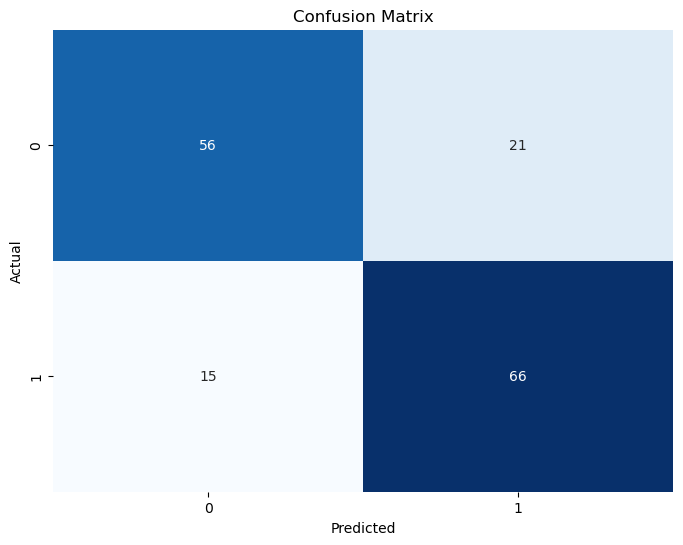

Classification Report:

              precision    recall  f1-score   support

      Benign       0.79      0.73      0.76        77
   Malignant       0.76      0.81      0.79        81

    accuracy                           0.77       158
   macro avg       0.77      0.77      0.77       158
weighted avg       0.77      0.77      0.77       158



In [6]:
# Predict on the validation set
y_pred = model.predict(X_val)
y_pred_binary = (y_pred > 0.5).astype("int32")

# Import necessary libraries
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate and plot the confusion matrix
cm = confusion_matrix(y_val, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Generate and print the classification report
print("Classification Report:\n")
print(classification_report(y_val, y_pred_binary, target_names=['Benign', 'Malignant']))


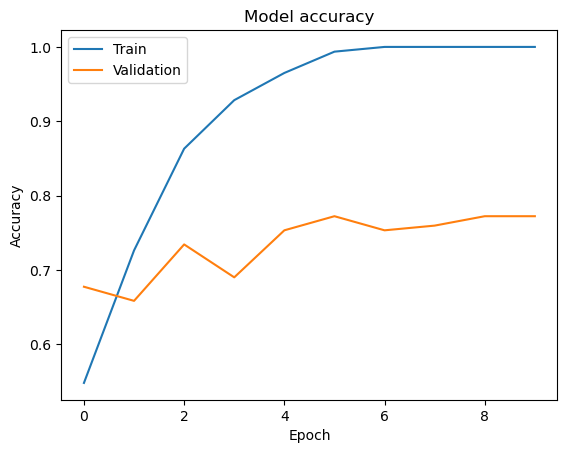

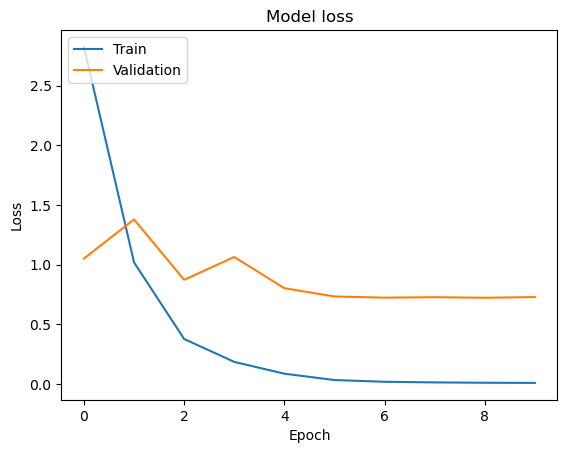

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [8]:
model.save('custom_resnet50_model.keras')

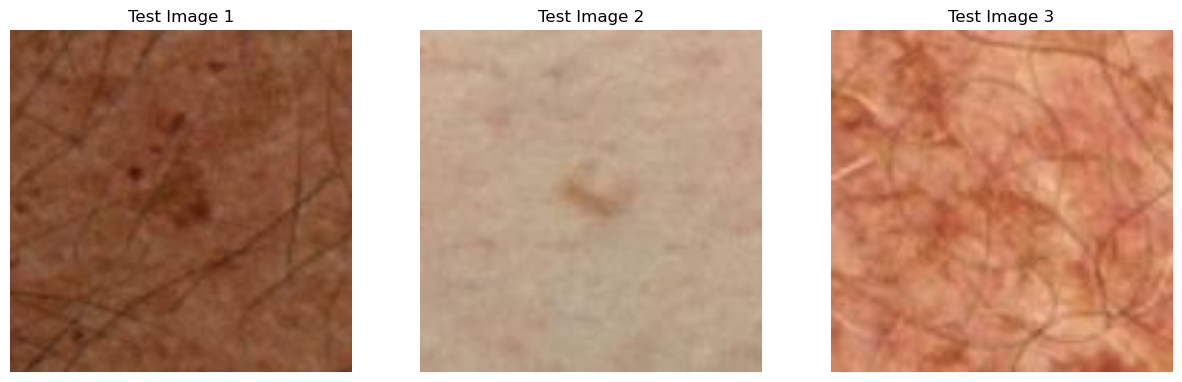

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted classes: ['Benign', 'Benign', 'Benign']


In [16]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt

# Load the test HDF5 file
test_hdf5_file_path = r'C:/Users/nirmi/test-image.hdf5'
test_hdf5_file = h5py.File(test_hdf5_file_path, 'r')

# Function to display images from the test HDF5 file
def display_test_images(hdf5_file, num_images=3):
    plt.figure(figsize=(15, 5))
    for i, key in enumerate(list(hdf5_file.keys())[:num_images]):
        image_data = hdf5_file[key][()]
        image = tf.image.decode_jpeg(image_data, channels=3)
        image = tf.image.resize(image, [224, 224])
        image = image / 255.0  # Normalize to [0, 1]

        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.numpy())
        plt.title(f"Test Image {i + 1}")
        plt.axis('off')
    
    plt.show()

# Function to preprocess and predict using the model
def preprocess_and_predict(hdf5_file, model, num_images=3):
    images = []
    for key in list(hdf5_file.keys())[:num_images]:
        image_data = hdf5_file[key][()]
        image = tf.image.decode_jpeg(image_data, channels=3)
        image = tf.image.resize(image, [224, 224])
        image = image / 255.0  # Normalize to [0, 1]
        image = tf.image.rgb_to_grayscale(image)  # Convert to grayscale
        images.append(image.numpy())

    images = np.array(images)
    images = np.expand_dims(images, axis=-1)  # Ensure the final shape is (batch_size, height, width, channels)

    # Predict using the trained model
    predictions = model.predict(images)
    
    # Convert predictions to class labels ("Benign" or "Malignant")
    predicted_classes = ['Malignant' if pred > 0.5 else 'Benign' for pred in predictions]
    return predicted_classes

# Display the first 3 images from the test set and make predictions
display_test_images(test_hdf5_file)
model = tf.keras.models.load_model('c://users/nirmi/custom_resnet50_model.keras')
predicted_classes = preprocess_and_predict(test_hdf5_file, model)
print("Predicted classes:", predicted_classes)
